In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import os, random                 
import seaborn as sns                          
import keras 
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import image  
from keras.models import Sequential    
from keras.layers import  Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input                               
from keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception     
from keras import regularizers                           #
from keras.optimizers import Adam,RMSprop,SGD,Adamax                        
from keras import layers                                 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

### DataPath

Contagem do número de ficheiros e quantidade de imagens em cada classe de doença de pele (**Urticaria**, **Psoriasis**, **Lupus**, **Dermatite**, **Melanoma**).

| Classe de Doença de Pele                                     | Conjunto de Treino | Conjunto de Teste |
|---------------------------------------------------------------|--------------------|-------------------|
| URTICARIA HIVES                                              | 416                | 53                |
| PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES        | 483                | 350               |
| LUPUS AND OTHER CONNECTIVE TISSUE DISEASES                   | 416                | 105               |
| ATOPIC DERMATITIS PHOTOS                                     | 483                | 123               |
| MELANOMA SKIN CANCER NEVI AND MOLES                          | 453                | 115               |

Total number of images in [URTICARIA HIVES] in train set: 416
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 483
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 416
Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 483
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 453
Total number of images in [URTICARIA HIVES] in test set: 53
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 350
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 115


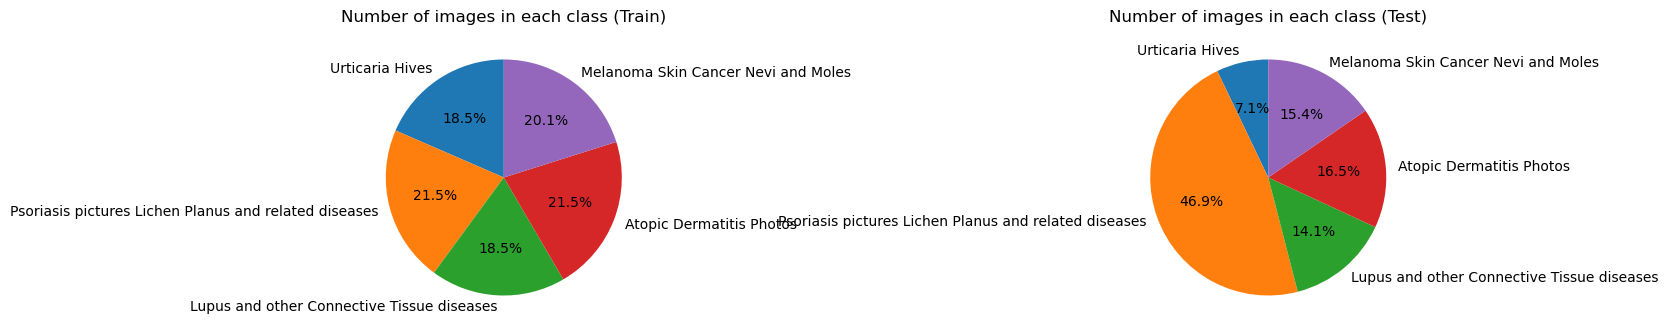

In [2]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

## Defenição de funções 

### Obtenção dos Dados de Treino, Validação e Teste

Definição de uma função para obter os dados de treino, validação e teste.

#### Funcionalidades Principais:

- **Função `get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32)`:** Retorna geradores de dados para treino, validação e teste.
- **Pré-processamento dos Dados de Treino:** Utiliza `ImageDataGenerator` para aplicar transformações nos dados de treino, como redimensionamento, normalização e aumento de dados.
- **Divisão em Conjuntos de Treino e Validação:** Divide os dados de treino em conjuntos de treino e validação.
- **Pré-processamento dos Dados de Teste:** Aplica redimensionamento e normalização nos dados de teste.
- **Geradores de Dados:** Cria geradores de dados para treino, validação e teste, utilizando as configurações definidas.


In [3]:
# Função para obter os dados de treino e validação
def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=10
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

### Treino dos Modelos

Definição de uma função para treinar os modelos de classificação.

#### Funcionalidades Principais:

- **Função `train_model(model, train_generator, validation_generator, epochs)`:** Compila e treina o modelo de classificação.
- **Compilação do Modelo:** Utiliza o otimizador 'adam' e a função de perda 'categorical_crossentropy' para compilar o modelo. Além disso, utiliza a métrica de accuracy e precisão durante o treino.
- **Treinoo do Modelo:** Treina o modelo utilizando os geradores de dados de treino e validação, durante o número especificado de épocas.
- **Retorno do Modelo e Histórico:** Retorna o modelo treinado e o histórico de treino.


In [4]:
# Função para treinar os modelos
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

### Avaliação dos Modelos

Definição de uma função para avaliar o desempenho dos modelos.

#### Funcionalidades Principais:

- **Função `evaluate_model(model, history, test_generator, test_folder)`:** Avalia o modelo de classificação.
- **Previsões:** Utiliza o modelo para fazer previsões sobre os dados de teste.
- **Conversão das Previsões para Rótulos:** Converte as previsões em rótulos para comparação com os rótulos verdadeiros.
- **Cálculo da Precisão, Recall e AUC:** Calcula a precisão, recall e AUC do modelo utilizando as previsões e os rótulos verdadeiros.
- **Visualização dos Resultados:** Plot da precisão, recall, AUC, bem como a precisão e perda de treino e validação em cada época.

In [5]:
# Função para avaliar os modelos
from sklearn.metrics import precision_score, recall_score, accuracy_score

def evaluate_model(model, history, test_generator, test_folder): 
    # Prever
    y_pred = model.predict(test_generator)

    # Converter as previsões em rótulos
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calcular precisão, recall e exatidão
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # O cálculo da AUC não é possível sem y_score (probabilidades de classe)
    # Pode comentar ou remover a seguinte linha
    # auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted', multi_class='ovr')

    # Gráfico da precisão e perda de treino e validação em cada época
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Gráfico da precisão de treino e validação do modelo
    plt.plot(history.history['accuracy'], label='Precisão de Treino')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico da perda de treino e validação em cada época
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    # Remover o cálculo da AUC pois não é possível sem y_score
    # print("AUC:", auc)

    plt.show()

### Guardar os Modelos

Definição de uma função para salvar os modelos treinados, juntamente com sua avaliação e histórico de treino.

#### Funcionalidades Principais:

- **Função `save_model(model, model_name, history, train_folder)`:** Salva o modelo treinado, sua avaliação e histórico de treinamento.
- **Criação de Pastas:** Cria pastas para salvar o modelo, a avaliação e o histórico, se não existirem.
- **Salvamento do Modelo:** Salva o modelo treinado em formato h5.
- **Avaliação do Modelo:** Avalia o modelo e salva a avaliação em uma figura.
- **Salvamento da Arquitetura do Modelo:** Plota e salva a arquitetura do modelo em uma imagem.
- **Salvamento do Histórico de Treinamento:** Salva o histórico de treinamento em um arquivo CSV.


In [8]:
# Função para guardar os modelos
def save_model(model, model_name, history, train_folder, test_folder, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

## Modelos

### CNN 2D

In [23]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_5 (Resizing)          (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['resizing_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']        

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.


2024-04-04 01:53:59.353344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.2085

2024-04-04 01:55:40.996349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 109s 2s/step - loss: 1.6096 - accuracy: 0.2085 - val_loss: 1.6083 - val_accuracy: 0.2143


2024-04-04 01:55:48.008826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 10s 425ms/step
Precisão: 0.18368460110870957
Recall: 0.16621983914209115
Exatidão: 0.16621983914209115


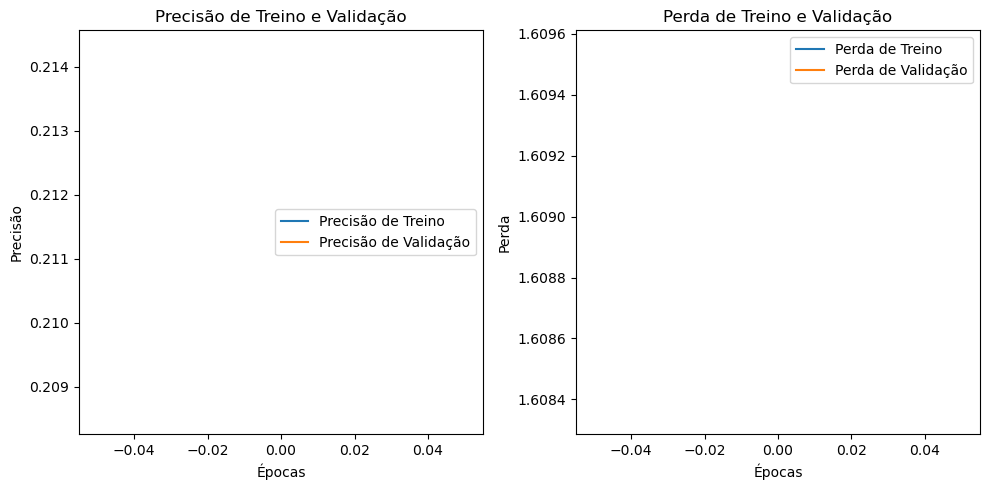

2024-04-04 01:55:58.559559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 10s 419ms/step
Precisão: 0.18368460110870957
Recall: 0.16621983914209115
Exatidão: 0.16621983914209115


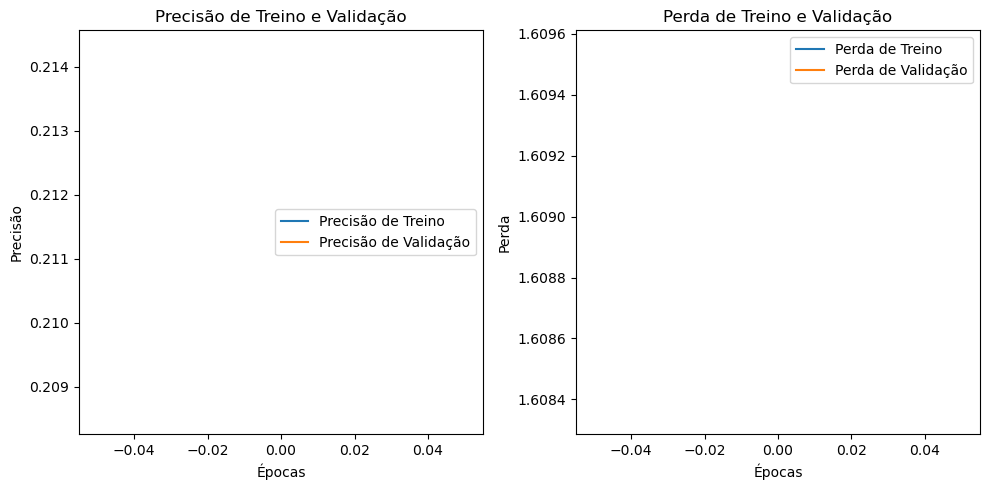

<Figure size 640x480 with 0 Axes>

In [18]:
# Definição da arquitetura da CNN
def CNN_model(input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

    return model

# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=1):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo CNN
    model = CNN_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Guardar o modelo
    save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

# Execução do modelo CNN
run_cnn_model(train_folder, test_folder)

### ResNet50

In [22]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_4 (Resizing)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['resizing_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']        

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.


2024-04-04 01:20:09.293918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 2.1925 - accuracy: 0.2707

2024-04-04 01:23:57.885049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 243s 4s/step - loss: 2.1925 - accuracy: 0.2707 - val_loss: 1.6330 - val_accuracy: 0.2009


2024-04-04 01:24:12.181450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6523 - accuracy: 0.2119 - precision_2: 0.2069

2024-04-04 01:27:50.129194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 232s 4s/step - loss: 1.6523 - accuracy: 0.2119 - precision_2: 0.2069 - val_loss: 1.6088 - val_accuracy: 0.2143 - val_precision_2: 0.0000e+00


2024-04-04 01:28:04.259571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 22s 913ms/step
Precisão: 0.027185202222397918
Recall: 0.1648793565683646
Exatidão: 0.1648793565683646


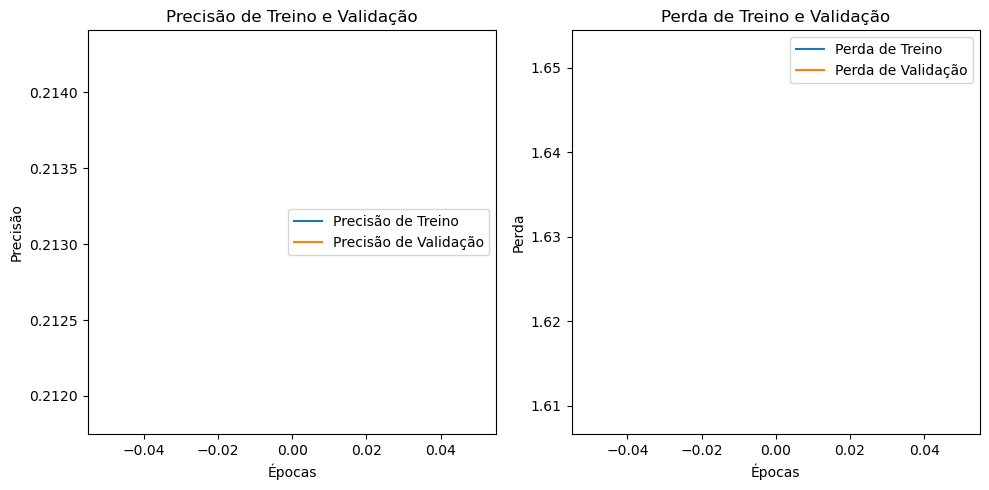

2024-04-04 01:28:27.140120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 22s 913ms/step
Precisão: 0.027185202222397918
Recall: 0.1648793565683646
Exatidão: 0.1648793565683646


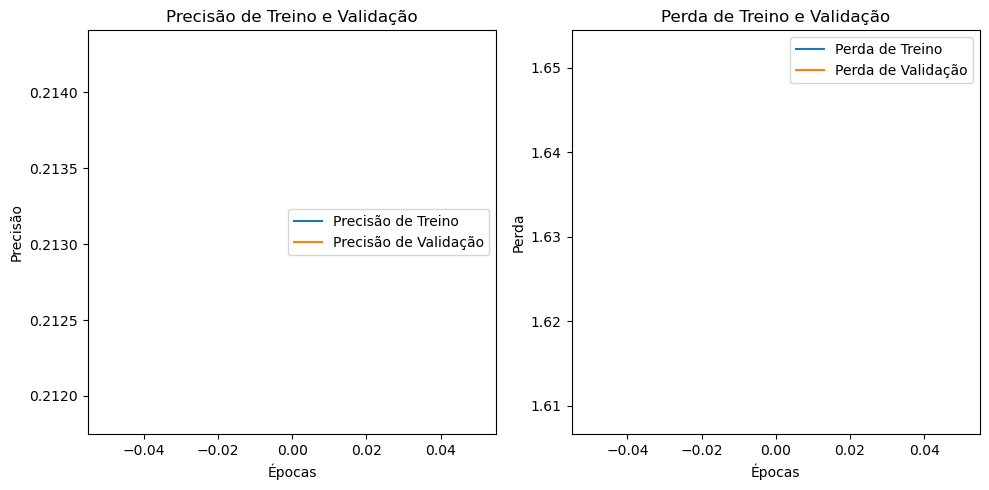

<Figure size 640x480 with 0 Axes>

In [10]:
# Definição da arquitetura da ResNet
def ResNet_model(input_shape=(250, 250, 3)):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=1):
    # Obtendo os dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo ResNet
    model = ResNet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo ResNet
run_resnet_model(train_folder, test_folder)

### VGG16

In [24]:
# Obter o modelo
model = VGG16_model()

# Sumário do modelo 
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 resizing_6 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1475

Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.


2024-04-04 01:57:55.149817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6384 - accuracy: 0.1986

2024-04-04 02:06:50.948342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 576s 10s/step - loss: 1.6384 - accuracy: 0.1986 - val_loss: 1.6082 - val_accuracy: 0.2143


2024-04-04 02:07:30.770288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 66s 3s/step
Precisão: 0.22011945748190528
Recall: 0.4691689008042895
Exatidão: 0.4691689008042895


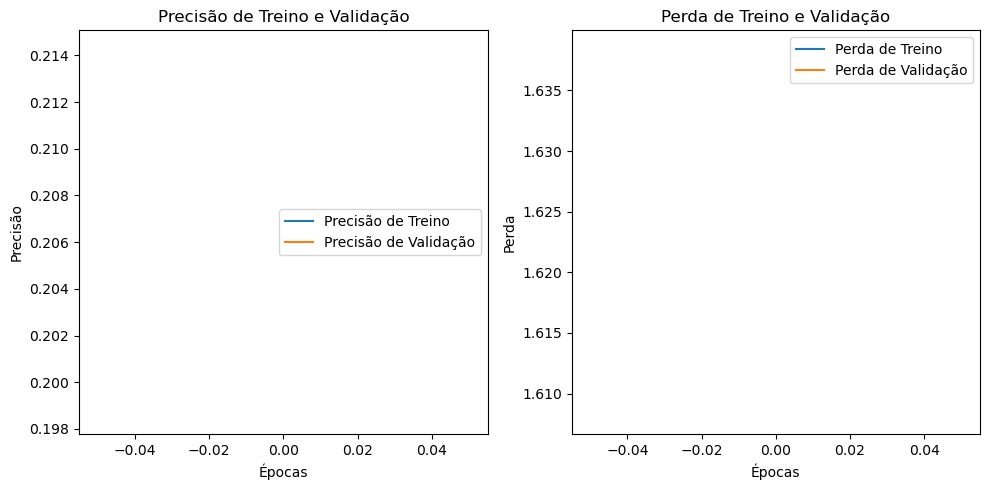

2024-04-04 02:08:37.080544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 67s 3s/step
Precisão: 0.22011945748190528
Recall: 0.4691689008042895
Exatidão: 0.4691689008042895


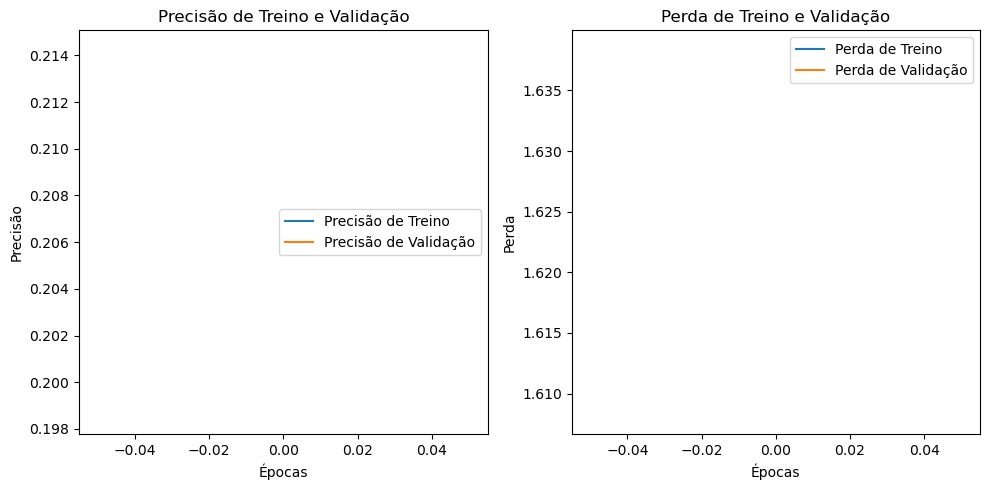

<Figure size 640x480 with 0 Axes>

In [20]:
# Função para definir a arquitetura do modelo VGG16
def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Redimensionar as imagens de entrada para 224x224 para corresponder à forma de entrada do VGG16
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importar o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Remover a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Camada de saída
    x = Flatten()(vgg16_layer)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Execução do modelo VGG16
def run_vgg16_model(train_folder, test_folder, epochs=1):
    # Obtenção de dados
    train_generator, validation_generator, test_generator = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo VGG16
    model = VGG16_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino o modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Guardar o modelo
    save_model(model, 'VGG16_model', history, train_folder, test_folder, test_generator)

# Execução do modelo VGG16
run_vgg16_model(train_folder, test_folder)